# Анализ обратной связи о работе чата психологической поддержки в компании Додо

## Входные данные:

В компании Додо был проведен опрос сотрудников: **Используете ли вы бесплатный чат психологической поддержки от Alter? Если нет, то почему?**

На основе опроса была составлена excel таблица с ответами сотрудников. Таблица включает в себя 2203 ответа и разделена тремя призаками: департамент, ответ и должность.

## Задача:
Исследовать данные и определить осведомленность сотрудников о доступности чата психологической поддержки.

## Анализ:

In [97]:
# для работы с таблицей импортируем библиотеку Pandas
import pandas as pd

# для построения графиков импортируем Matplotlib и Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
# прочитаем нашу таблицу и выведем первые 5 строк
data = pd.read_excel('data/Response.xlsx')
data.head()

,Абакан-1,"Я не использую чат, потому что нету в нем надобности. Но, если понадобится обязательно использую",сотрудник кухни
0,Абинск-1,Потому что мне это не надо,сотрудник кухни
1,Абинск-1,Не нужен,курьер
2,Абинск-1,Не нуждаюсь,курьер
3,Абинск-1,Значит у меня всё хорошо.,курьер
4,Абинск-1,Боюсь что не конфидециально,сотрудник кухни


**Для удобства работы с таблицей добавим названия столбцам.**

In [99]:
data.columns = ['Department', 'Response', 'Position']
data

,Department,Response,Position
0,Абинск-1,Потому что мне это не надо,сотрудник кухни
1,Абинск-1,Не нужен,курьер
2,Абинск-1,Не нуждаюсь,курьер
3,Абинск-1,Значит у меня всё хорошо.,курьер
4,Абинск-1,Боюсь что не конфидециально,сотрудник кухни
...,...,...,...
2198,Якутск-2,Никогда о таком не слышал,сотрудник кухни
2199,Якутск-2,не вижу смысла,сотрудник кухни
2200,Якутск-2,Нет времени.,сотрудник кухни
2201,Якутск-2,не знал о нем до этого момнта,сотрудник кухни


**Посмотрим, есть ли пропуски или пустые значения в данных:**

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2203 entries, 0 to 2202
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Department  2203 non-null   object
 1   Response    2203 non-null   object
 2   Position    2203 non-null   object
dtypes: object(3)
memory usage: 51.8+ KB


**Пропуски отсутствуют. Итак, у нас имеется таблица с 2203 отзывами о чате.**

**Посмотрим какие уникальные ответы встречаются чаще всего.**

In [101]:
data['Response'].value_counts().head(30)


Не нуждаюсь                               88
Нет необходимости                         72
Нет                                       36
Не использую                              32
Не требуется                              28
Не нужен                                  25
Не хочу                                   24
Не нужно                                  17
Все хорошо                                17
Не знаю                                   17
Нет надобности                            14
Всё хорошо                                14
Не знаю о нем                             11
нет необходимости                         11
Не знала о нем                            11
Не знал                                   10
Нет нужды                                 10
Не знаю что это                            9
Не знал о нем                              9
Мне это не нужно                           9
Не нуждаюсь.                               9
не нуждаюсь                                8
Зачем?    

**Судя по отзывам, сотрудники чаще всего не используют или не нуждаются в чате. Однако есть и те, кто не знает о доступности данного сервиса. Попробуем выявить долю таких сотрудников. Но для начала проведет некоторые преобразования.**

**Для анализа нам нужно привести отзыв к формату списка, состоящего из отдельных слов отзыва и вывести каждое слово в нижнем регистре для повышения эффективности поиска. Отзывы в формате "Нет необходимости" приведем к виду: ['нет', 'необходимости'].**

In [102]:
# для этого напишем простую функцию
def str_response(review):
    clean_rev = str(review).lower().split(' ')
    return clean_rev

# применим ее к нашему столбцу Response
data['Response'] = data['Response'].apply(str_response)

# выведем первые 5 строк таблицы для проверки
data['Response'].head(5)

0    [потому, что, мне, это, не, надо]
1                          [не, нужен]
2                       [не, нуждаюсь]
3      [значит, у, меня, всё, хорошо.]
4     [боюсь, что, не, конфидециально]
Name: Response, dtype: object

**Основной целью анализа данных является выявление доли сотрудников, которые не знают о существовании чата. Поиск таких сотрудников будем осуществлять по ключевым словам. Если ключевое слово втретится в отзыве, то мы можем отметить, что сотрудник не знает о том, что для него доступен чат.**

In [103]:
# напишем небольшую функцию, которая с помощью цикла 
# проверит каждый отзыв на наличие в нем ключевых слов
def get_status(response):
    key_words = ['знаю', 'низнал', 'знал', 'незнал', 'слышу', 
                 'слышал', 'слышала', 'такое', 'курсе', 
                 'ссылку', 'ссылка', 'ссылки', 'известно'
                 'довели', 'первый', 'впервые', 'расскажи', 
                 'теперь', 'слышно', 'забыл', 'забыла']
    for word in response:
        if word in key_words:
            return 1
            continue
        

# добавим в нашу таблицу столбец 'Do not know', в котором
# единицей будут помечены отзывы тех, кто не знает о чате
data['Do not know'] = data['Response'].apply(get_status)

# остальных пометим нулем
data['Do not know'] = data['Do not know'].fillna(0)

**Проверим как сработала наша функция. Выведем несколько отзывов, которые были отобраны:**

In [104]:
data[data['Do not know'] == 1].head(10)

,Department,Response,Position,Do not know
9,Аксай Россия-1,"[что, такое, телеграмм?]",курьер,1.0
10,Аксай Россия-1,"[я, и, не, знал, о, его, существовании.]",сотрудник кухни,1.0
26,Апатиты-1,"[даже, не, знаю, о, таком, чате.]",сотрудник кухни,1.0
27,Апрелевка-1,"[не, знал, о, нем]",сотрудник кухни,1.0
45,Астрахань-3,"[не, знал, о, существовании, ресурса]",сотрудник кухни,1.0
49,Астрахань-4,"[что, это, такое, ?]",сотрудник кухни,1.0
51,Ачинск-1,"[не, знаю, о, нем]",сотрудник кухни,1.0
55,Балаково-1,"[в, 1ые, слышу]",курьер,1.0
57,Балаково-1,"[не, знал]",сотрудник кухни,1.0
59,Балашиха-1,"[не, знаю, о, нем,, но, он, мне, и, не, нужен]",курьер,1.0


**Кажется функция сработала неплохо. Сразу можно добавить в личный топ отзыв [что, такое, телеграмм?] и удивиться мастерству сокращений в отзыве [в, 1ые, слышу]. =)**

**Теперь посмотрим сколько сотрудников не знают о чате или узнали о нем из опроса.**

In [105]:
data['Do not know'].value_counts()

0.0    1840
1.0     363
Name: Do not know, dtype: int64

In [106]:
data['Do not know'].value_counts(normalize=True)*100

0.0    83.522469
1.0    16.477531
Name: Do not know, dtype: float64

**Итого 363 сотрудника или 16% от всех опрошенных. Визуализируем это с помощью круговой диаграммы.**

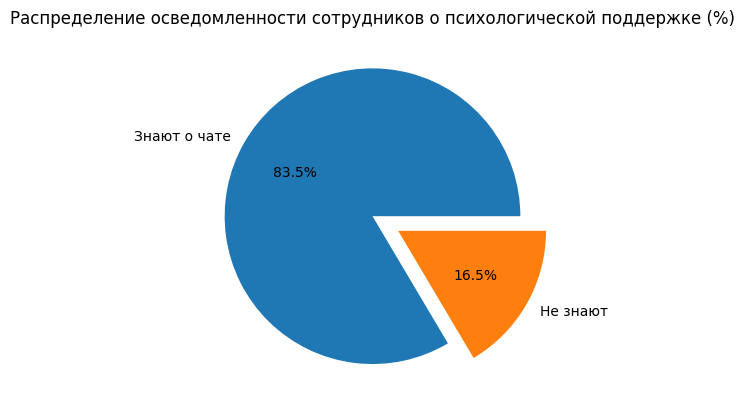

In [107]:
df1 = pd.DataFrame(data['Do not know'].value_counts().reset_index())
plt.pie(data=df1,x='Do not know',labels=['Знают о чате', 'Не знают'], explode=[0, 0.2], autopct='%.1f%%')
plt.title('Распределение осведомленности сотрудников о психологической поддержке (%)')

plt.show()

**Теперь рассмотрим этот же процент в привязке к подразделениям компании, чтобы выявить где осведомленность ниже.**

**Сгруппируем таблицу по подразделениям компании и отобразим по каждому процент тех, кто не знает о сервисе, и общее количество опрошенных.**

In [108]:
groupped = data.pivot_table(
    index='Department', 
    values=['Do not know', 'Response'], 
    aggfunc={'Do not know': 'mean', 'Response': 'count'}
    ).sort_values(by='Do not know', ascending=False).head(50)
groupped

,Do not know,Response
Department,,
Москва 18-4,1.000000,3
Ачинск-1,1.000000,1
Тюмень-4,1.000000,2
Северодвинск-1,1.000000,3
Наро-Фоминск-1,1.000000,1
Краснодар-4,1.000000,2
Камышин-1,1.000000,1
Барнаул-3,1.000000,1
Красноярск-5,1.000000,2


**Мы видим, что в подразделении Москва 18-4 все сотрудники, прошедшие опрос (значение 1.0 во втором столбце означает 100% тех, кто ответил, не знают о чате). Однако, в опросе поучаствовали всего 3 сотрудника (значение 3 в третьем столбце). Возможно эту информацию стоит довести до управляющего для дальнейшего знакомства с сотрудников с сервисом Альтер.**

**Также мы можем вывести статистику в каких подразделениях активнее всего проходили опрос.**

In [109]:
groupped_often = data.pivot_table(
    index='Department', 
    values=['Do not know', 'Response'], 
    aggfunc={'Do not know': 'mean', 'Response': 'count'}
    ).sort_values(by='Response', ascending=False).head(5)
groupped_often

,Do not know,Response
Department,,
Ногинск-1,0.000000,23
Офис,0.000000,22
Бугульма-1,0.062500,16
Челябинск-8,0.000000,15
Тобольск-1,0.071429,14


**Лидером по числу отзывов является подразделение Ногинск-1. Однако, мы не знаем сколько всего сотрудиков получили приглашение для участия в опросе, поэтому посчитать конверсию данного параметра невозможно.**

**Дополнительно можно отметить, что в подразделениях, в которых мы видим наибольшее число отзывов, очень низкий процет тех, кто не знает о существовании чата психологической поддержки.**

**Попробуем также рассмотреть признак должности в таблице.**

In [110]:
data['Position'].value_counts()

сотрудник кухни    1476
курьер              727
Name: Position, dtype: int64

**В опросе участвовали только сотрудники кухни и курьеры. Их 1476 и 727 человек соответственно. Посмотрим, есть ли зависимость должноти от осведомленности об услугах Альтер.**

In [111]:
groupped_position = data.pivot_table(
    index='Position', 
    values='Do not know', 
    aggfunc='mean'
    ).sort_values(by='Do not know', ascending=False).head(5)
groupped_position

,Do not know
Position,
курьер,0.170564
сотрудник кухни,0.161924


**Процент осведомленности для каждой должности одинаков и составляет примерно 17%. Поэтому можно сделать вывод, что тип трудовой деятельности не влияет на осведомленность.**

## Выводы:

- **Мы проанализировали данные с отзывами и определили долю тех, кто в компании не знает о доступности бесплатного чата психологической поддержки Альтер.**
- **Определили подразделения компании в которых наименьшая осведомленность о доступности сервиса.**
- **Определили подразделения компании, в которых сотрудники активнее всего проходили опрос.**
- **Сделали вывод о том, что на уровень осведомленности не влияет должность сотрудника.**